<div align='center'><font size="5" color='#353B47'>Opracowanie aplikacji do wyznaczania giełdowych decyzji inwestycyjnych opartej na analizie Big Data</font></div>
<div align='center'><font size="4" color="#353B47">Projekt Inżynierski</font></div>
<br>
<hr>

**<font color="#5963ab" size="4">Cel projektu</font>**

> Celem projektu jest opracowanie narzędzia do wspierania wyznaczania trendów na podstawie różnych danych dostępnych w internecie. Umożliwi to inwestorom podejmowanie bardziej trafnych i opartych na danych decyzji inwestycyjnych.

## <div id="summary">Spis Treści</div>

**<br><font size="2"><a href="#chap1">Konfiguracja środowiska</a></font>**
**<br><font size="2"><a href="#chap2">Wczytanie danych</a></font>**
**<br><font size="2"><a href="#chap3">Analiza danych</a></font>**
**<br><font size="2"><a href="#chap4">Prztwarzanie wstępne danych</a></font>**
**<br><font size="2"><a href="#chap5">Stowrzenie modeli</a></font>**
**<br><font size="2"><a href="#chap6">Backtesting modeli i optymalizacja</a></font>**
**<br><font size="2"><a href="#chap7">Ocena modeli</a></font>**
**<br><font size="2"><a href="#chap8">Zastosowanie wyników w rzeczywistości</a></font>**
**<br><font size="2"><a href="#chap9">Wnioski z uzyskanych danych</a></font>**
**<br><font size="2"><a href="#chap10">Raport końcowy</a></font>**


<div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Konfiguracja środowiska </h1></div>

In [158]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023_Combined.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/USA_Cons_Sent_PCH.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/USA_GDP_PCH.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/SP500_Earn_Yield.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/SP500_DIV_YIELD.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/SP500_CAPE_Ratio.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/SP500_PBV.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/USA_FED_Effective_Rate_PCH.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/SP500_Price_Sales_Ratio.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/USA_CPI_AUC_SL_PCH.csv
/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023/USA_FED_Effective_Rat

In [156]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import data
!pip install yfinance
import yfinance as yf

# Data analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot

#Text formatting
from pprint import pprint

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Wczytanie danych</h1></div>



**<font color="#5963ab" size="4">Jakie dane są wykorzystane i ich pochodzenie.</font>**

>Oto dane użyte w tym notatniku, oraz ich pochodzenie:
>* **Notowania S&P 500**  - pobrane z użyciem biblioteki *yfinance*
>* **Nagłówki artykułów z New York Times**  - pobrane za pomocą API dostarczanego przez NYT - https://developer.nytimes.com/
>* **Dane makroekonomiczne gospodarki USA i podstawowe wskaźniki dla S&P 500**  - pobrane z:
>  * https://data.nasdaq.com/
>  * https://fred.stlouisfed.org/
>  * https://www.bls.gov/
>  * https://stooq.pl/
>* **Wyszukiwanie frazy "S&P 500" w wyszukiwarce** - pobrano dane z wyszukiwarki google ze strony - https://trends.google.com/trends/
>
>Powyższe dane są w dalszych etapach poddane analizie oraz wstępnie przetworzone w celu wykorzystania ich a modelach uczenia maszynowego.
>
>W tym notatniku skupiono się na danych związancyh z indeksem S&P 500, gospodarką Stanów Zjednoczonych, nagłówkami artykułów z NYT, trendami wyszukiwania frazy "S&P 500" w wyszukiwarce google. Na podstawie danych z notowań wyznaczono też wiele wskazników pomocnych przy analizie technicznej, których także użyto do predykcji notowań. Dane pochodzą z okresu od 01/01/2004 do 08/31/2023.

**<font color="#5963ab" size="4">Notowania S&P 500</font>**

In [3]:
# fetch S&P 500 financial datadata
sp500 = yf.Ticker("^GSPC")

#print all index info
#pprint("Info")
#pprint(sp500.info)

#get stock quotes
sp500 = sp500.history( period="max" )
start_date = '2004-01-01'
end_date = '2023-08-31'
sp500 = sp500[(sp500.index >= start_date) & (sp500.index <= end_date)]

# make all column headers and index name lowercase
sp500.columns = sp500.columns.str.lower()
sp500.index.name = sp500.index.name.lower()

sp500

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,0.0,0.0
2004-01-05 00:00:00-05:00,1108.479980,1122.219971,1108.479980,1122.219971,1578200000,0.0,0.0
2004-01-06 00:00:00-05:00,1122.219971,1124.459961,1118.439941,1123.670044,1494500000,0.0,0.0
2004-01-07 00:00:00-05:00,1123.670044,1126.329956,1116.449951,1126.329956,1704900000,0.0,0.0
2004-01-08 00:00:00-05:00,1126.329956,1131.920044,1124.910034,1131.920044,1868400000,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-25 00:00:00-04:00,4389.379883,4418.459961,4356.290039,4405.709961,3296180000,0.0,0.0
2023-08-28 00:00:00-04:00,4426.029785,4439.560059,4414.979980,4433.310059,2957230000,0.0,0.0
2023-08-29 00:00:00-04:00,4432.750000,4500.140137,4431.680176,4497.629883,3354820000,0.0,0.0


**<font color="#5963ab" size="4">Nagłówki New York Times </font>**

In [4]:
# load the dataset
nyt_hl = pd.read_csv('/kaggle/input/new-york-times-headlines-news/NYT_Headlines.csv', index_col='date',  encoding='utf-8')
nyt_hl.index = pd.to_datetime(nyt_hl.index)
nyt_hl

,headline
date,
2004-01-01,FreeMarkets Agrees to Buy Auction Unit of Covi...
2004-01-01,National Briefing | South: Arkansas: Assembly ...
2004-01-01,Clark Courts Veterans in Swing Through South
2004-01-01,"Paid Notice: Deaths PAONE, NICOLA"
2004-01-01,The Time We Thought We Knew
...,...
2023-08-31,Yale’s President Announces He Will Step Down
2023-08-31,7 Spectacular Space Images From August
2023-08-31,"Trump, Waiving Arraignment, Pleads Not Guilty ..."


**<font color="#5963ab" size="4">Dane makroekonomiczne gospodarki USA i podstawowe wskaźniki dla S&P 500</font>**

In [5]:
# load the dataset
macro_data = pd.read_csv('/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023_Combined.csv', index_col='date')
macro_data.index = pd.to_datetime(macro_data.index)
# make all column headers lowercase
macro_data.columns = macro_data.columns.str.lower()
macro_data

,cape,div_growth,div_yield,earn_yield,pbv,pe,price_sales_ratio,10usy_bond_yield,cons_sent,cons_sent_percent_change,cpiaucsl_pch,fed_effective_rate,fed_effect_rate_pch,gdp,gdp_percent_change,pmi_index,unemploy_rate
date,,,,,,,,,,,,,,,,,
2004-01-01,27.66,8.16,1.61,4.40,3.03,22.73,1.56,4.26,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-02,27.66,8.16,1.61,4.40,3.03,22.72,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-03,27.66,8.16,1.61,4.40,3.03,22.71,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-04,27.66,8.16,1.61,4.40,3.03,22.70,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-05,27.66,8.16,1.61,4.40,3.03,22.70,1.56,4.39,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,31.36,7.33,1.50,3.85,4.47,25.76,2.61,4.23,69.5,-2.93,0.17,5.33,0.21,26798.60,1.01,46.4,3.8
2023-08-28,31.36,7.33,1.50,3.85,4.47,25.75,2.61,4.21,69.5,-2.93,0.17,5.33,0.21,26798.60,1.01,46.4,3.8
2023-08-29,31.36,7.33,1.50,3.85,4.47,25.74,2.61,4.12,69.5,-2.93,0.17,5.33,0.21,26798.60,1.01,46.4,3.8


In [185]:
# divide data to two data frames
# data related with S&P 500 
sp500_rates = macro_data[['pe', 'cape', 'earn_yield','pbv', 'price_sales_ratio','div_yield', 'div_growth']]
sp500_rates

,pe,cape,earn_yield,pbv,price_sales_ratio,div_yield,div_growth
date,,,,,,,
2004-01-01,22.73,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-02,22.72,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-03,22.71,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-04,22.70,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-05,22.70,27.66,4.40,3.03,1.56,1.61,8.16
...,...,...,...,...,...,...,...
2023-08-27,25.76,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-28,25.75,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-29,25.74,31.36,3.85,4.47,2.61,1.50,7.33


In [186]:
# data related with USA ecomony
usa_eco_rates = macro_data[[' gdp', 'gdp_percent_change', 'unemploy_rate','pmi_index', 'cpiaucsl_pch','fed_effective_rate', 'fed_effect_rate_pch','10usy_bond_yield', 'cons_sent',
       'cons_sent_percent_change']]
usa_eco_rates

,gdp,gdp_percent_change,unemploy_rate,pmi_index,cpiaucsl_pch,fed_effective_rate,fed_effect_rate_pch,10usy_bond_yield,cons_sent,cons_sent_percent_change
date,,,,,,,,,,
2004-01-01,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.26,103.8,12.10
2004-01-02,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-03,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-04,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-05,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.39,103.8,12.10
...,...,...,...,...,...,...,...,...,...,...
2023-08-27,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.23,69.5,-2.93
2023-08-28,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.21,69.5,-2.93
2023-08-29,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.12,69.5,-2.93


**<font color="#5963ab" size="4">Trendy wyszukiwania "S&P 500" w wyszukiwarce google</font>**

In [6]:
# load the dataset
goog_trend = pd.read_csv('/kaggle/input/s-and-p500-google-trends/SP500_GoogleTrends.csv', index_col='date')
goog_trend.index = pd.to_datetime(goog_trend.index)
goog_trend

,month_trend
date,
2004-01-01,10
2004-02-01,9
2004-03-01,8
2004-04-01,9
2004-05-01,7
...,...
2023-04-01,35
2023-05-01,35
2023-06-01,38


<div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Analiza danych</h1></div>

**<font color="#5963ab" size="4">Dane z szeregów czasowych.</font>**

>W danym notatniku mamy do czynienia z danymi z szeregów czasowych. Dane z szeregów czasowych (ang. "time series data") to rodzaj danych, w którym informacje są zbierane, zapisywane lub pomiarowe w określonych momentach w czasie lub w regularnych odstępach czasu. Te dane reprezentują zmienne, które ewoluują w czasie i pozwalają na analizę, modelowanie i prognozowanie przyszłych wartości na podstawie wcześniejszych obserwacji. 
>
>Dane z szeregów czasowych mają pewne charakterystyczne cechy, takie jak sezonowość, trendy, cykliczność i autokorelacja, które można wykorzystać do analizy i modelowania. Analiza danych szeregów czasowych może pomóc w identyfikacji wzorców, prognozowaniu przyszłych notowań, zarządzaniu ryzykiem i podejmowaniu właściwych decyzji opartych na danych.






**<font color="#5963ab" size="4">sp500</font>**




>Indeks **S&P 500**, pełna nazwa "Standard & Poor's 500 Index", jest jednym z najważniejszych indeksów giełdowych na świecie. Jest on używany do pomiaru ogólnej wydajności amerykańskiego rynku akcji. Obejmuje on 500 największych i najbardziej znaczących spółek notowanych na giełdzie amerykańskiej, reprezentujących różne sektory gospodarki.
>
>S&P 500 jest szeroko stosowany jako wskaźnik, który pomaga inwestorom i analitykom śledzić ogólną kondycję rynku akcji w Stanach Zjednoczonych. W skład indeksu wchodzą firmy takie jak Apple, Microsoft, Amazon, Google (Alphabet), czy Berkshire Hathaway.
>
>Indeks S&P 500 jest ważnym punktem odniesienia dla wielu inwestorów i profesjonalistów branży finansowej i jest używany do oceny trendów giełdowych, porównywania wyników portfeli inwestycyjnych oraz analizy ogólnego klimatu na rynku.

In [7]:
# check for missing values in each column
missing_columns = sp500.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
# print all sp500 data info
print()
pprint(sp500.info())


'Missing values in column'
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4950 entries, 2004-01-02 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          4950 non-null   float64
 1   high          4950 non-null   float64
 2   low           4950 non-null   float64
 3   close         4950 non-null   float64
 4   volume        4950 non-null   int64  
 5   dividends     4950 non-null   float64
 6   stock splits  4950 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 309.4 KB
None


<Axes: xlabel='date'>

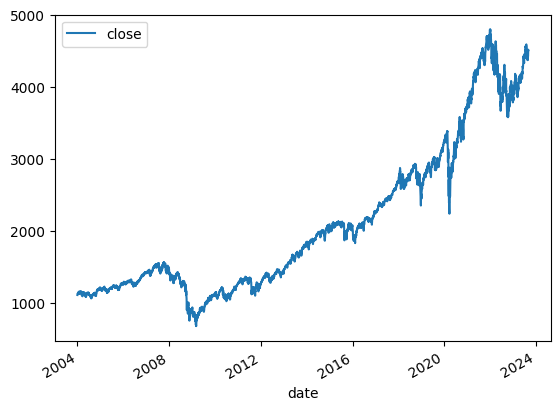

In [8]:
# plot prices
sp500.plot.line(y="close", use_index = True)


>Nie wydaje się, aby dane wykazały jakąkolwiek zauważalną sezonowość w poszczególnych latach. Zamiast tego pokazuje trend wzrostowy, a nie zachowanie cykliczne. Można zauważyć też kilka większych spadków. W 2008r. spadek spowodowany przez światowy kryzys. Na początku 2020 zauważalny spadek cen był związany z pandemią Covid-19. Ostatni widoczny spadek był widoczny w 2022r.. Ogólnie widać bardzo duży wzrost w wartości indeksu w przeciągu niecałych 20 lat.`


Text(0.5, 1.0, 'Volume')

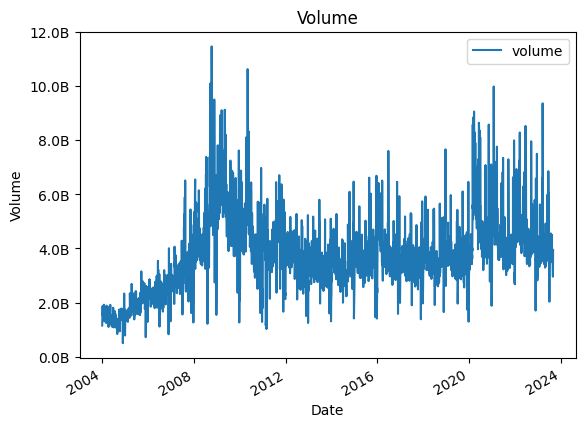

In [9]:
# plot volume
volume_plot = sp500.plot.line(y="volume", use_index = True)
volume_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%1.1fB' % (x * 1e-9)))
volume_plot.set_xlabel("Date")
volume_plot.set_ylabel("Volume")
volume_plot.set_title('Volume')

>Wykres wykazuje znaczny szum wynikający z zastosowania skali dziennej. Wybierając średni miesięczny wolumen obrotu, a nie dzienny wolumen obrotu, oczekuje się, że wynikowa wizualizacja będzie bardziej zrozumiała i atrakcyjna wizualnie.

Text(0.5, 1.0, 'Average monthly volume')

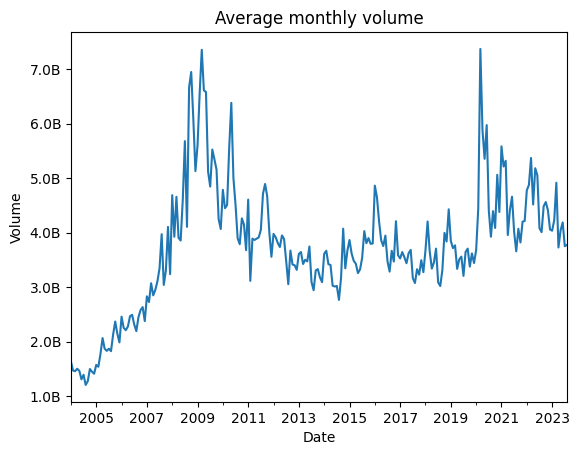

In [10]:
# plot of average monthly volume
sp500_volume = sp500['volume'].copy()
sp500_volume = sp500_volume.resample('1M').mean()
volume_plot_avg_m= sp500_volume.plot.line(y="volume", use_index = True)
volume_plot_avg_m.set_xlabel("Date")
volume_plot_avg_m.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%1.1fB' % (x * 1e-9)))
volume_plot_avg_m.set_ylabel("Volume")
volume_plot_avg_m.set_title('Average monthly volume')

>Wykres jest dużo bardziej czytelny dzięki zwiekszeniu interwału pomiędzy poszczególnymi danymi do miesiąca czasu. Widać na tym wykresie początkowy trend wzrostowy, a poźniej ustabilizowanie ilości wolumenu w obrocie. Są dwa widoczne okresy większych obrotów w okolicy kryzysu z 2008r. oraz początku pandemii Covid-19.

In [11]:
# seasonability
sp500_copy = sp500.copy()
sp500_copy['year'] = sp500_copy.index.year
sp500_copy['month'] = sp500_copy.index.month
print(sp500_copy['year'].unique())
sp500_copy

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


,open,high,low,close,volume,dividends,stock splits,year,month
date,,,,,,,,,
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,0.0,0.0,2004,1
2004-01-05 00:00:00-05:00,1108.479980,1122.219971,1108.479980,1122.219971,1578200000,0.0,0.0,2004,1
2004-01-06 00:00:00-05:00,1122.219971,1124.459961,1118.439941,1123.670044,1494500000,0.0,0.0,2004,1
2004-01-07 00:00:00-05:00,1123.670044,1126.329956,1116.449951,1126.329956,1704900000,0.0,0.0,2004,1
2004-01-08 00:00:00-05:00,1126.329956,1131.920044,1124.910034,1131.920044,1868400000,0.0,0.0,2004,1
...,...,...,...,...,...,...,...,...,...
2023-08-25 00:00:00-04:00,4389.379883,4418.459961,4356.290039,4405.709961,3296180000,0.0,0.0,2023,8
2023-08-28 00:00:00-04:00,4426.029785,4439.560059,4414.979980,4433.310059,2957230000,0.0,0.0,2023,8
2023-08-29 00:00:00-04:00,4432.750000,4500.140137,4431.680176,4497.629883,3354820000,0.0,0.0,2023,8


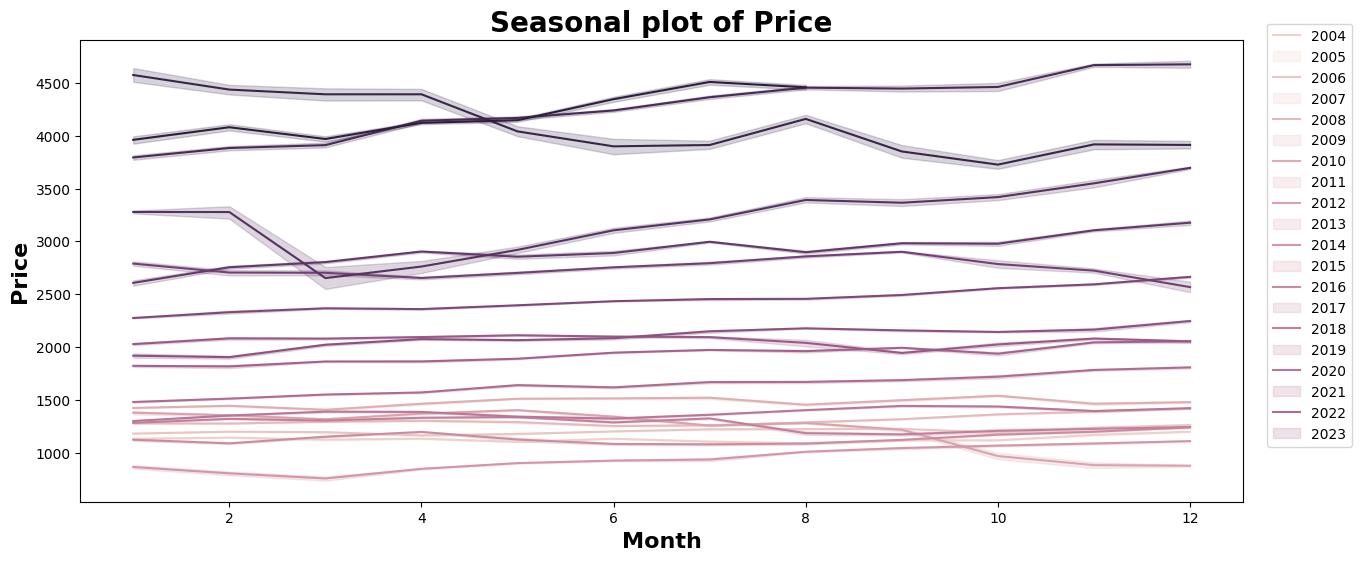

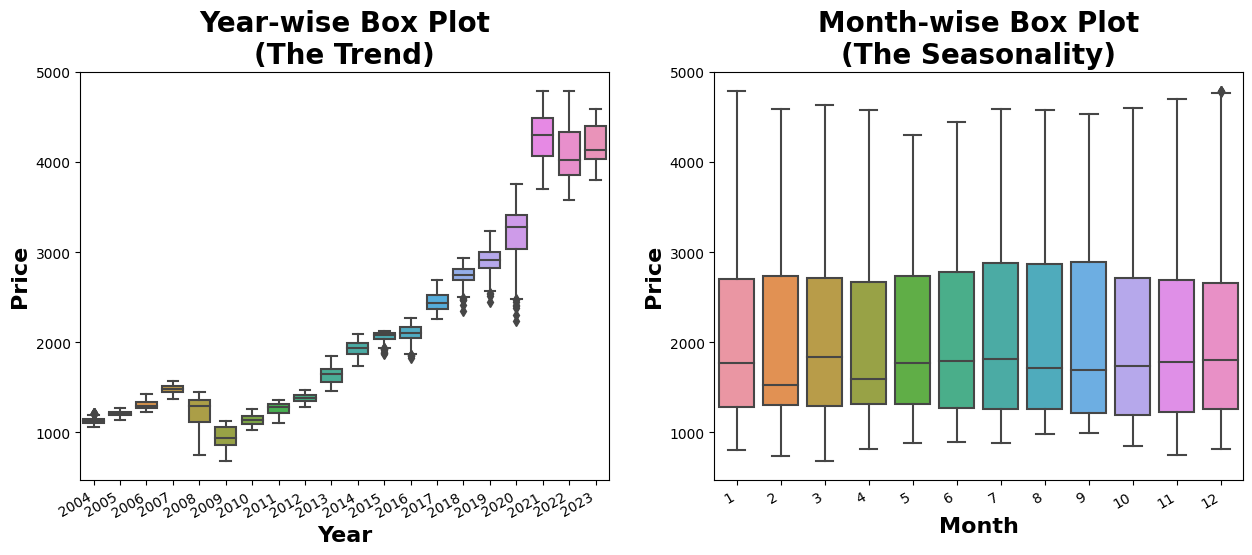

In [12]:
# seasonability of price column
column = "close"
# create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=sp500_copy['month'], y=sp500_copy[column], hue = sp500_copy['year'])

# format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=sp500_copy['year'], y=sp500_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=sp500_copy['month'], y=sp500_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Price**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Chociaż można zauważyć większą zmienność notowań dla ostatnich lat.

**Year wise Box Plot**

>Na tym wykresie widać ogólny trend wzrostowy. Nie jest widoczna sezonowść. Natomiast można zauważyć znaczne wartości odstające dla 2008r. oraz ostatnich lat. To sugeruje większą zmienność w tych okresach. Dla reszty notowań wartości sa dosyć mocno ograniczone w wąskim zakresie.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Można jednak zauważyć, że mediana dla miesięcy luty oraz kwiecień jest troszkę niższa od pozostałych miesięcy. 

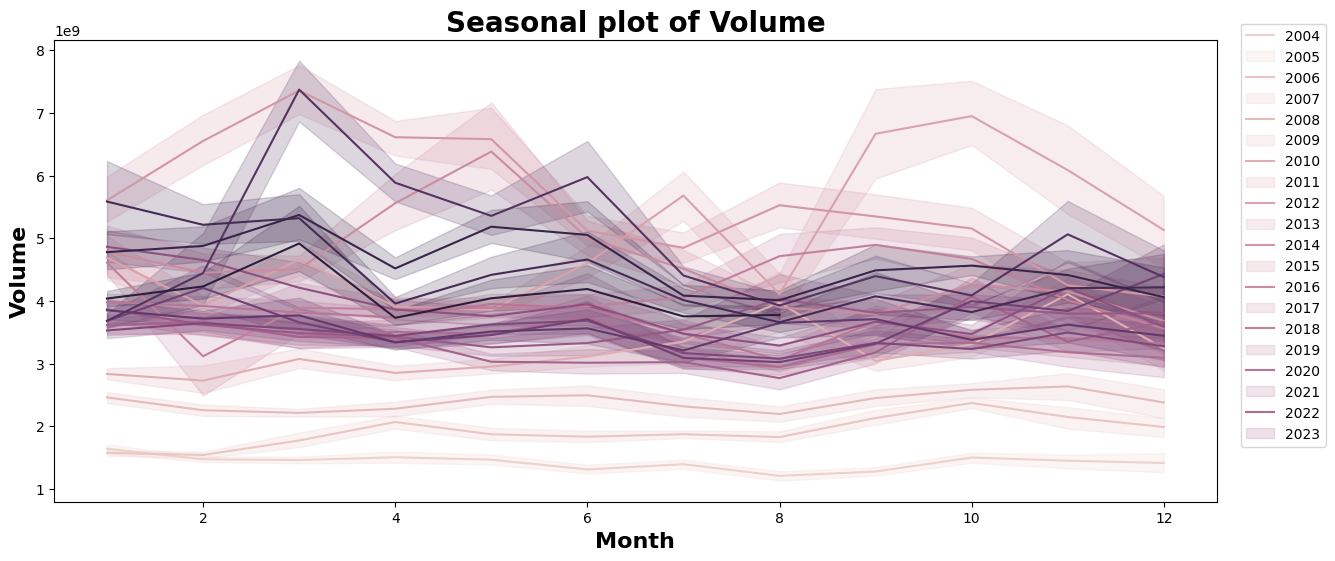

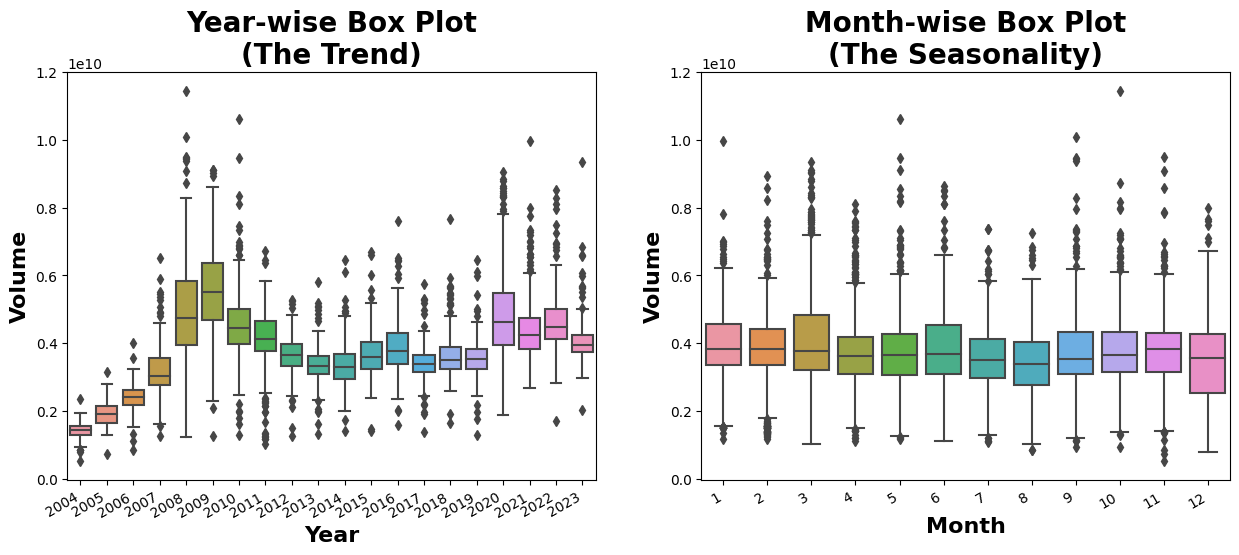

In [13]:
# seasonability of volume column
column = "volume"
# create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=sp500_copy['month'], y=sp500_copy[column], hue = sp500_copy['year'])

# format the plot
ax.set_title('Seasonal plot of Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=sp500_copy['year'], y=sp500_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=sp500_copy['month'], y=sp500_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Volume**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Można zauważyć mniejszą lość wolumenu dla miesięcy letnich czyli lipca i sierpnia.

**Year wise Box Plot**

>Na tym wykresie jest widoczny początkowy z największą medianą dla roku 2009. Nastepnie ilość wolumenu w obiegu spada i stabilizuje w ostatnich latach. Największa zmienność jest dla lat związanych z większymi spadkami notowań. To zapewne wynika z większej dynamiki cen oraz nerwowości inwestorów. Znaczne wartości odstające pojawiają się od roku 2007 wskazują większą zmienność wolumenu, która stale się utrzymuje.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Nie można stwerdzić isteniejącej sezonowości 

Text(0, 0.5, 'Volume')

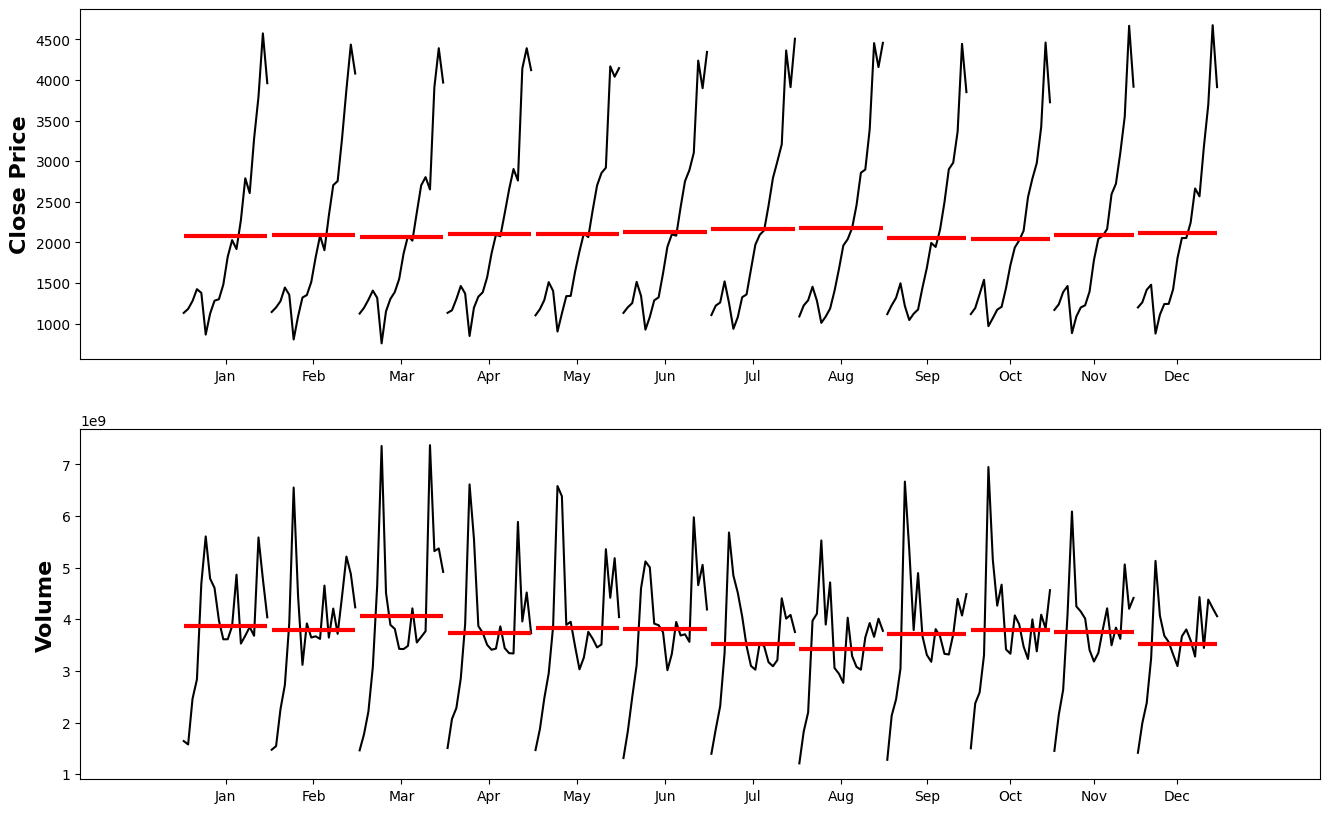

In [14]:
# aggregating sp500 stock quotes to a monthly scaled index
sp500_month_agg = sp500.resample('1M').mean()


# # Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(sp500_month_agg['close'], ax=ax[0]);
ax[0].set_ylabel('Close Price', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(sp500_month_agg['volume'], ax=ax[1]);
ax[1].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

>Wykresy te aggreguja wartości ze wszsytkich lat dla poszczególnych miesięcy. grupowania.  Dzięki temu można potencjalnie zauważyć wyraźniejszy obraz potencjalnej miesięcznej sezonowości.
>
>Staje się oczywiste, że nie ma sezonowości dla notowań. Średnia miesięcznych cen otwarcia i zamknięcia S&P 500 pozostaje stosunkowo stała.
>
>Dla wolumenu jest widoczna większa zmienność, ale nie jest duża. Średnia miesięcznych ilości obrotów na indeksie S&P 500 różni się nieznacznie dla poszczególnych miesięcy. Widoczne sa mniejsze wartośći dla miesięcy letnich.

**<font color="#5963ab" size="4">nyt_hl</font>**

>New York Times jest jednym z najbardziej wpływowych i rozpoznawalnych dzienników w Stanach Zjednoczonych i na całym świecie.Jest to amerykańska gazeta z siedzibą w Nowym Jorku, znana ze wszechstronnego relacjonowania wiadomości krajowych i międzynarodowych, polityki, biznesu, kultury i wielu innych tematów. Dlatego analiza nagłówków może dawać wskazówki o sytuacji geopolitycznej i ekonomicznej na świecie, co może uda się z powodzeniem wykorzystać do predykcji notowań.

In [15]:
# check for missing values in each column
missing_columns = nyt_hl.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
print()
# print all problematic rows
null_mask = nyt_hl.isnull().any(axis=1)
null_rows = nyt_hl[null_mask]
pprint("Null rows")
pprint(null_rows)
print()
# delete null rows
nyt_hl = nyt_hl.dropna()

'Missing values in column'
headline    562
dtype: int64

'Null rows'
           headline
date               
2004-01-18      NaN
2004-02-08      NaN
2004-02-10      NaN
2004-02-22      NaN
2004-02-23      NaN
...             ...
2022-01-20      NaN
2022-01-20      NaN
2022-10-14      NaN
2022-10-28      NaN
2022-10-28      NaN

[562 rows x 1 columns]



In [16]:
# group all articles for dates to lists
nyt_hl= nyt_hl.groupby(nyt_hl.index).agg({'headline': list})
nyt_hl

,headline
date,
2004-01-01,[FreeMarkets Agrees to Buy Auction Unit of Cov...
2004-01-02,"[Homeless in America, Yes, Today, Tony Cragg, ..."
2004-01-03,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T..."
2004-01-04,"[Wanted: Young Delegates, Corrections, How to ..."
2004-01-05,"[Cowboys Preparing To Take Next Step, Paid Not..."
...,...
2023-08-27,"[Flashback: Your Weekly History Quiz, August 2..."
2023-08-28,[Man Accused of Injecting Substance Into Neigh...
2023-08-29,[President of Powerful Realtors’ Group Resigns...


In [89]:
# print all nyt_hl data info
pprint(nyt_hl.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7182 entries, 2004-01-01 to 2023-08-31
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    7182 non-null   object
 1   art_amount  7182 non-null   int64 
 2   word_count  7182 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 224.4+ KB
None


Index(['headline', 'art_amount', 'word_count'], dtype='object')

In [18]:
# sum articles for all dates
nyt_hl['art_amount'] = nyt_hl['headline'].str.len()
nyt_hl

,headline,art_amount
date,,
2004-01-01,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224
2004-01-02,"[Homeless in America, Yes, Today, Tony Cragg, ...",70
2004-01-03,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158
2004-01-04,"[Wanted: Young Delegates, Corrections, How to ...",516
2004-01-05,"[Cowboys Preparing To Take Next Step, Paid Not...",182
...,...,...
2023-08-27,"[Flashback: Your Weekly History Quiz, August 2...",63
2023-08-28,[Man Accused of Injecting Substance Into Neigh...,120
2023-08-29,[President of Powerful Realtors’ Group Resigns...,135


Text(0.5, 1.0, 'Average monthly published articles')

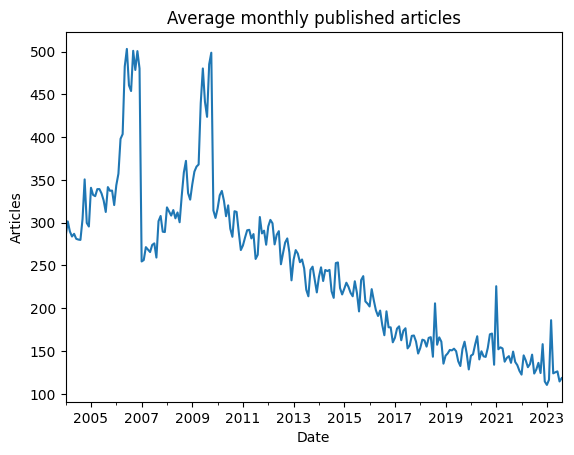

In [19]:
# plot of average monthly amount of published articles 
nyt_hl_sum = nyt_hl['art_amount'].copy()
nyt_hl_sum = nyt_hl_sum.resample('1M').mean()
art_avg_m= nyt_hl_sum.plot.line( use_index = True)
art_avg_m.set_xlabel("Date")
art_avg_m.set_ylabel("Articles")
art_avg_m.set_title('Average monthly published articles')

> Z powyższego wykresu widać niestety duży trend spadkowy w ilości publikowanych artykułów przez NYT. Sa też dwa okresy zwiększonej ilości publikacji. Niestety nie jest to dobrą waidomościa dla wyznacznia predykcji inwestowania. Nierównomierne rozłożenie danych w czasie czyli ich niezbalansowanie to istotny problem. Ma on wpływ na skuteczność modeli uczenia maszynowego i może prowadzić do niepożądanych efektów. 

In [20]:
# count words for all dates
def count_words(text_list):
    sum = 0
    for text in text_list:
        words = text.split() 
        sum+= len(words)
    return sum

nyt_hl['word_count'] = nyt_hl['headline'].apply(count_words)
nyt_hl

,headline,art_amount,word_count
date,,,
2004-01-01,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529
2004-01-02,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433
2004-01-03,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000
2004-01-04,"[Wanted: Young Delegates, Corrections, How to ...",516,3001
2004-01-05,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244
...,...,...,...
2023-08-27,"[Flashback: Your Weekly History Quiz, August 2...",63,548
2023-08-28,[Man Accused of Injecting Substance Into Neigh...,120,1142
2023-08-29,[President of Powerful Realtors’ Group Resigns...,135,1271


Text(0.5, 1.0, 'Average monthly words in articles')

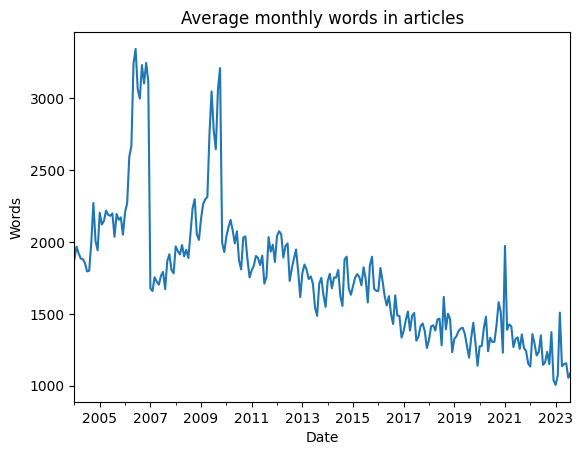

In [21]:
# plot of average monthly amount of published articles 
nyt_hl_sum = nyt_hl['word_count'].copy()
nyt_hl_sum = nyt_hl_sum.resample('1M').mean()
art_avg_m= nyt_hl_sum.plot.line( use_index = True)
art_avg_m.set_xlabel("Date")
art_avg_m.set_ylabel("Words")
art_avg_m.set_title('Average monthly words in articles')

> Powyższy wykres pokrywa się z poprzednim wykresem. Widać dużo większą ilość słów dla lat z pierwszych lat zebranych danych. 

In [22]:
# seasonability
nyt_hl_copy = nyt_hl.copy()
nyt_hl_copy['year'] = nyt_hl_copy.index.year
nyt_hl_copy['month'] = nyt_hl_copy.index.month
print(nyt_hl_copy['year'].unique())
nyt_hl_copy

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


,headline,art_amount,word_count,year,month
date,,,,,
2004-01-01,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529,2004,1
2004-01-02,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433,2004,1
2004-01-03,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000,2004,1
2004-01-04,"[Wanted: Young Delegates, Corrections, How to ...",516,3001,2004,1
2004-01-05,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244,2004,1
...,...,...,...,...,...
2023-08-27,"[Flashback: Your Weekly History Quiz, August 2...",63,548,2023,8
2023-08-28,[Man Accused of Injecting Substance Into Neigh...,120,1142,2023,8
2023-08-29,[President of Powerful Realtors’ Group Resigns...,135,1271,2023,8


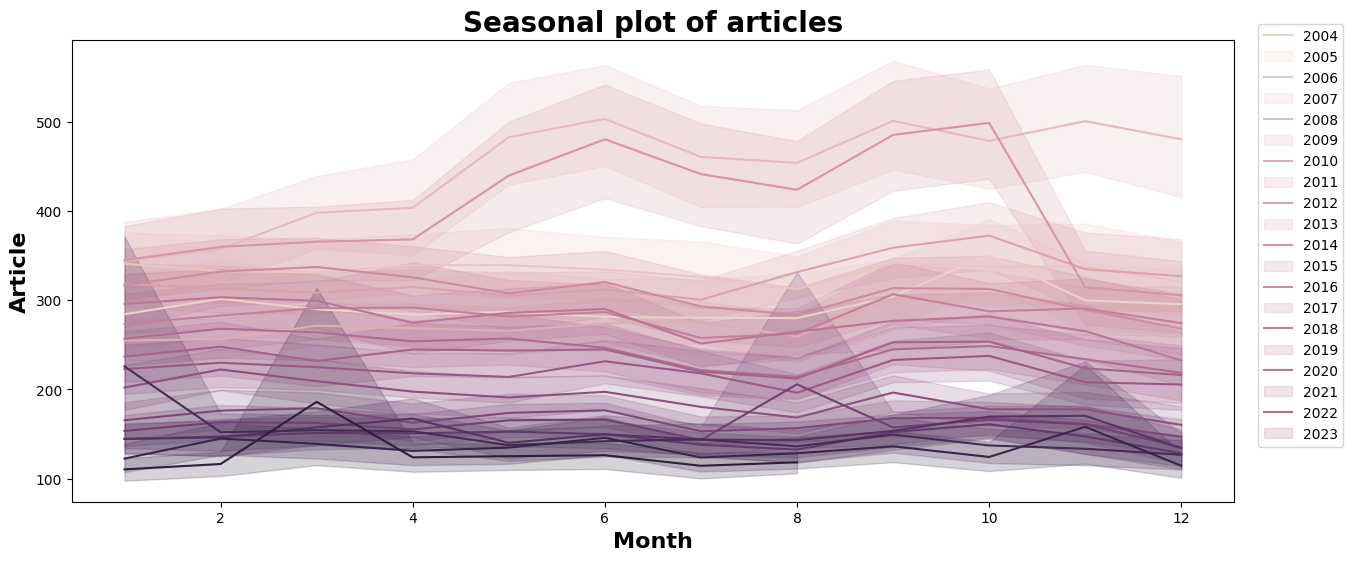

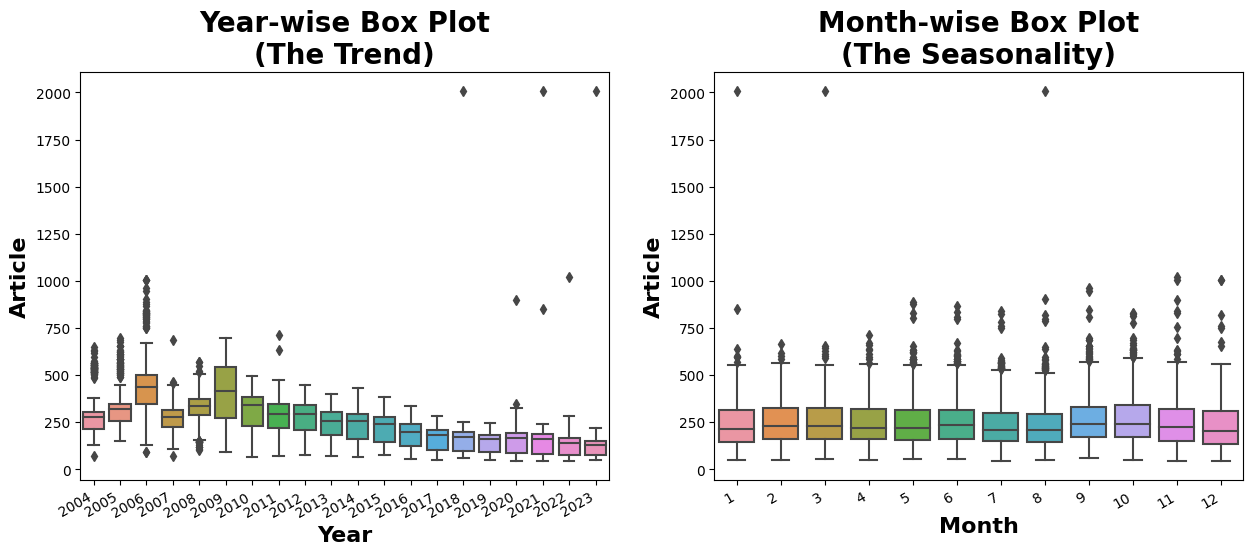

In [24]:
# seasonability of art_amount column
column = "art_amount"
# create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=nyt_hl_copy['month'], y=nyt_hl_copy[column], hue = nyt_hl_copy['year'])

# format the plot
ax.set_title('Seasonal plot of articles', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=nyt_hl_copy['year'], y=nyt_hl_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=nyt_hl_copy['month'], y=nyt_hl_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Articles**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Można zauważyć inne wartości dla poszczegółnych lat oraz większą zmienność dla lat z dużą ilością artykułów

**Year wise Box Plot**

>Na tym wykresie jest widoczny początkowy wzrost z największą medianą dla lat 2006 i 20009. Nastepnie ilość artykułów. Największa zmienność jest dla lat z największa ilością notowań. Znaczne wartości odstające pojawiają się  różnych okresach. W ostatnich latach widać dni w których nadzywczajnie było dużo publikacji co jest zastanwawiające jak rzetelne są te dane pobrane z API NYT.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Nie można stwerdzić isteniejącej sezonowości 

Text(0, 0.5, 'Words')

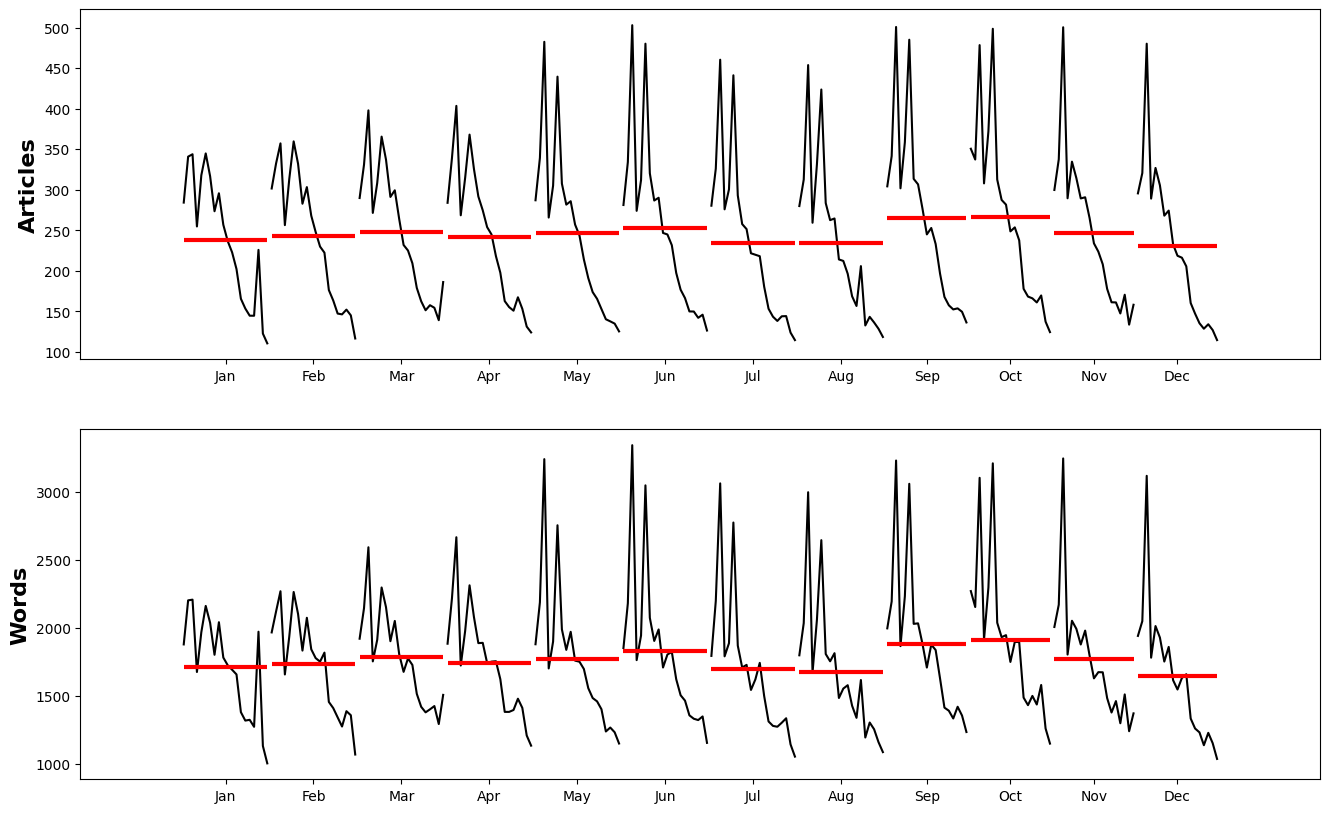

In [29]:
# aggregating nyt_hl to a monthly scaled index
nyt_hl_copy = nyt_hl.copy()
del nyt_hl_copy['headline']

nyt_hl_month_agg = nyt_hl_copy.resample('1M').mean()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(nyt_hl_month_agg['art_amount'], ax=ax[0]);
ax[0].set_ylabel('Articles', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(nyt_hl_month_agg['word_count'], ax=ax[1]);
ax[1].set_ylabel('Words', fontsize = 16, fontdict=dict(weight='bold'))

>Nie widać dużej zmienności dla poszczególnych miesięcy dla tych danych. Powoduje to, że nie ma sezonowości w ilości publikacji.

**<font color="#5963ab" size="4">sp500_rates</font>**

>Wskaźniki dla akcji, indeksów to liczby lub metryki, które pomagają inwestorom, analitykom finansowym i traderom ocenić wydajność i zdrowie rynku giełdowego, konkretnych akcji lub instrumentów finansowych. Istnieje wiele różnych wskaźników giełdowych, z których każdy koncentruje się na innych aspektach rynku.

In [187]:
# load the dataset
macro_data = pd.read_csv('/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023_Combined.csv', index_col='date')
macro_data.index = pd.to_datetime(macro_data.index)
# make all column headers lowercase
macro_data.columns = macro_data.columns.str.lower()
macro_data

usa_eco_rates = macro_data[[' gdp', 'gdp_percent_change', 'unemploy_rate','pmi_index', 'cpiaucsl_pch','fed_effective_rate', 'fed_effect_rate_pch','10usy_bond_yield', 'cons_sent',
       'cons_sent_percent_change']]
usa_eco_rates.info()

#divide data to two data frames, data related with S&P 500 and USA ecomony
sp500_rates = macro_data[['pe', 'cape', 'earn_yield','pbv', 'price_sales_ratio','div_yield', 'div_growth']]
sp500_rates.info()


,pe,cape,earn_yield,pbv,price_sales_ratio,div_yield,div_growth
date,,,,,,,
2004-01-01,22.73,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-02,22.72,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-03,22.71,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-04,22.70,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-05,22.70,27.66,4.40,3.03,1.56,1.61,8.16
...,...,...,...,...,...,...,...
2023-08-27,25.76,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-28,25.75,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-29,25.74,31.36,3.85,4.47,2.61,1.50,7.33


In [190]:
# check for missing values in each column
missing_columns = sp500_rates.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)

# print all goog_trend data info
print()
pprint(sp500_rates.info())

'Missing values in column'
pe                   0
cape                 0
earn_yield           0
pbv                  0
price_sales_ratio    0
div_yield            0
div_growth           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183 entries, 2004-01-01 to 2023-08-31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pe                 7183 non-null   float64
 1   cape               7183 non-null   float64
 2   earn_yield         7183 non-null   float64
 3   pbv                7183 non-null   float64
 4   price_sales_ratio  7183 non-null   float64
 5   div_yield          7183 non-null   float64
 6   div_growth         7183 non-null   float64
dtypes: float64(7)
memory usage: 448.9 KB
None


>**P/E Ratio** - (kolumna - 'pe')
>
>P/E (Price-to-Earnings ratio) to stosunek ceny akcji do zysku na akcje. Pomaga ocenić, czy akcje są przecenione (niski P/E) lub nadwycenione (wysoki P/E).

Text(0.5, 1.0, 'P/E Ratio - S&P 500')

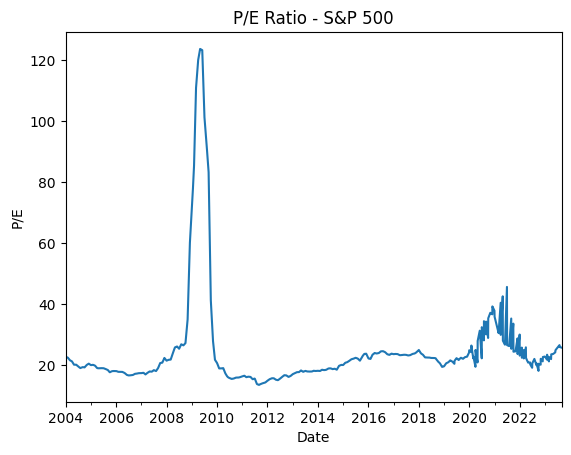

In [204]:
# plot P/E
sp500_pe_plot = sp500_rates['pe'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/E")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/E Ratio - S&P 500')

(10.0, 50.0)

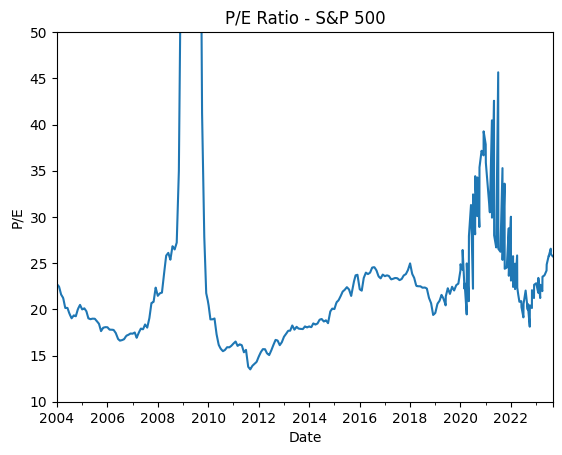

In [206]:
# # plot P/E, set_ylim
sp500_pe_plot = sp500_rates['pe'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/E")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/E Ratio - S&P 500')
sp500_pe_plot.set_ylim(10, 50)

> Od razu rzcua się w oczy na wykresie Cean/Zysk duży pik w 2009 roku. Ten wystrzał w górę jest związaney z osiąganiem niskich zysków przez firmy spowodowany kryzsem z 2008r. Dodatkowo 2009r sytuacja się stabilizowała i wyceny spółek poszły do góry. Co spowodowało, aż taką wielkość tego współczynnika.  Wysokie wskaźniki P/E obserwowane w 2009 roku były odzwierciedleniem skrajnych warunków rynkowych w tym okresie. W miarę jak gospodarka wracała do wzrostu, a zyski spółek się poprawiały, wskaźniki P/E stopniowo się normalizowały.
>
>W okresie 2020 do 2022 widać dużą zmienność. Wskażnik w tym okresie także osiągał dużę wartości. Co także jest spowowdowane wieloma czynnikami takimi między innymi jak pandemia czy polityka fiskalna i monetrna państw w tym szczególnie USA.

>**CAPE  Ratio** - (kolumna - 'cape')
>
>CAPE (Cyclically Adjusted Price-to-Earnings) to wskaźnik oceny wyceny akcji, który został opracowany przez laureata Nagrody Nobla, Roberta Shillera. Jest to miara, która uwzględnia inflację i cykl gospodarczy przy ocenie, czy rynki akcji są przeceniane lub nadwyceniane. 
>
>Wskaźnik ten porównuje aktualną cenę akcji do średniego zysku firmy na jedną akcję, skorygowanego o inflację, w ciągu ostatnich 10 lat. Główną ideą CAPE jest to, że przy użyciu wieloletniego przeciętnego zysku eliminuje się krótkoterminowe wahania cyklu gospodarczego. Wskaźnik ten pomaga inwestorom oceniać, czy rynki akcji są wyceniane na podstawie długoterminowych fundamentów, czy może występuje przecena lub nadwyżka wyceny.

Text(0.5, 1.0, 'CAPE Ratio - S&P 500')

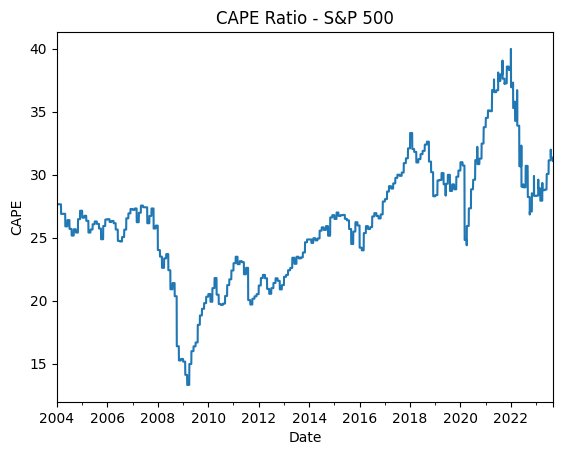

In [207]:
# plot CAPE
sp500_pe_plot = sp500_rates['cape'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("CAPE")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('CAPE Ratio - S&P 500')

> Nie ma tutaj jak w P/E bardzo gwałtownych zmian wartości. Dzięki wzięciu wyników finansowcyh z ostanich 10 lat wykres jest bardziej odporny na krótkoterminowe wahania notowań. Minimum lokalne i globalne CAPE osiągał w czasach większych spadków indeksu. Obecnie jego wartość wynosi ponad 30 i jest to dosyć znacznie powyżęj średniej wartości.

>**Earning Yield** - (kolumna - 'earn_yield')
>
>Earnings Yield to wskaźnik finansowy używany do oceny rentowności inwestycji w akcje lub spółki. Jest to stosunek zysku netto firmy do ceny jej akcji lub kapitalizacji rynkowej (wartości rynkowej spółki na giełdzie). Earnings Yield mierzy, ile procentowo zysku netto generowanego przez spółkę przypada na jedną jednostkę jej akcji. Wartość tego wskaźnika można interpretować podobnie jak wskaźnik P/E (Price-to-Earnings Ratio), ale w odwrotny sposób. Wskaźnik P/E mierzy, ile razy cena akcji zawiera się w zysku netto, podczas gdy Earnings Yield wyraża zysk netto jako procent ceny akcji.
>
>Earnings Yield może być przydatny w porównywaniu różnych spółek lub rynków giełdowych pod kątem potencjalnej rentowności inwestycji. Wyższy Earnings Yield oznacza, że inwestorzy mogą spodziewać się wyższej rentowności z inwestycji w akcje danej spółki.

Text(0.5, 1.0, 'Earning Yield - S&P 500')

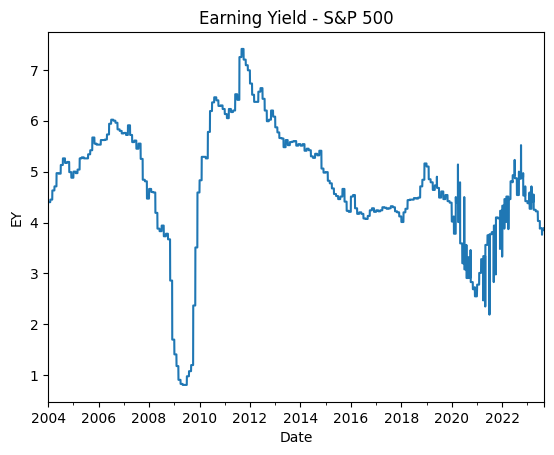

In [208]:
# plot Earning Yield
sp500_pe_plot = sp500_rates['earn_yield'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("EY")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Earning Yield - S&P 500')

> Ten wskażnik jest odwrotnością P/E, więc można wysunać podobne wnioski. Widzimy, że obecnie EY nie jest zbyt wysoko co oznacza, że rentowność nie jest duża w porównaniu do notowań historycznych.

>**PBV** - (kolumna - 'pbv')
>
>Wskaźnik PBV (Price-to-Book Value) jest wskaźnikiem finansowym, który służy do oceny wyceny spółki na podstawie jej wartości księgowej. Jest to stosunek ceny rynkowej akcji spółki do jej wartości księgowej na jedną akcję.
>
>Niższy wskaźnik PBV może sugerować, że akcje są bardziej przystępne cenowo, podczas gdy wyższy wskaźnik może wskazywać na przecenę. Wartości PBV poniżej 1 mogą sugerować, że akcje są wyceniane poniżej wartości księgowej. 

Text(0.5, 1.0, 'PBV - S&P 500')

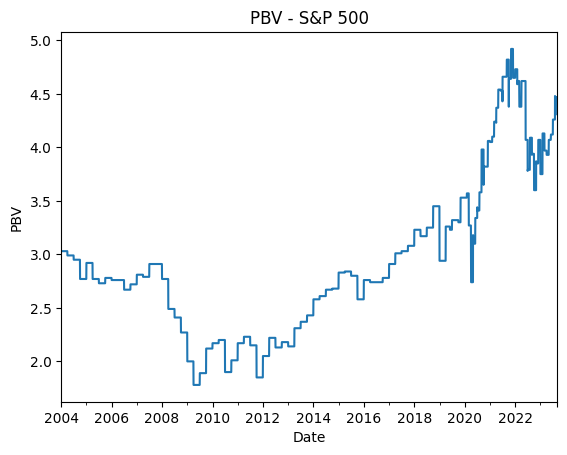

In [209]:
# plot Earning Yield
sp500_pe_plot = sp500_rates['pbv'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("PBV")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('PBV - S&P 500')

>Na wykresie widać, że w ostatnich 20 latach indeks dla 500 najwiekszych spółek USA miał wartość PBV dużo powyżej 1. Nie tak dawno osiągał swoje maksima, osiągając wartość prawie 5. 
>
>Jednak wskaźnik PBV powinien być interpretowany w kontekście zmian w jakie zachodzą w gospodarce. Ponieważ różne branże mogą mieć różne typowe zakresy wartości PBV. Ostatnio coraz większe znaczenia mają firmy z branży technologicznej, a nie przemysłowej, które zazwyczaj posiadają mniej aktywów. Może to powodować większą wartość PBV.

>**P/S Ratio** - (kolumna - 'prices_sales_ratio')
>
>Wskaźnik P/S (Price-to-Sales Ratio), nazywany również wskaźnikiem wyceny na podstawie przychodów, to wskaźnik finansowy wykorzystywany do oceny wyceny spółek. Jest to stosunek ceny akcji danej spółki do jej przychodów ze sprzedaży na jedną akcję lub na jednostkę udziałową.
>
> Niższy wskaźnik P/S może sugerować, że spółka jest bardziej przystępnie wyceniana w porównaniu do swoich przychodów, podczas gdy wyższy wskaźnik P/S może wskazywać na przecenę lub oczekiwania rynku dotyczące przyszłego wzrostu przychodów.
Wskaźnik P/S jest szczególnie przydatny w analizie spółek, które generują duże przychody, ale niekoniecznie osiągają znaczne zyski netto. Jest on również często stosowany w analizie firm technologicznych oraz spółek z sektora wzrostowego, gdzie perspektywa wzrostu przychodów jest kluczowa.


Text(0.5, 1.0, 'P/S Ratio - S&P 500')

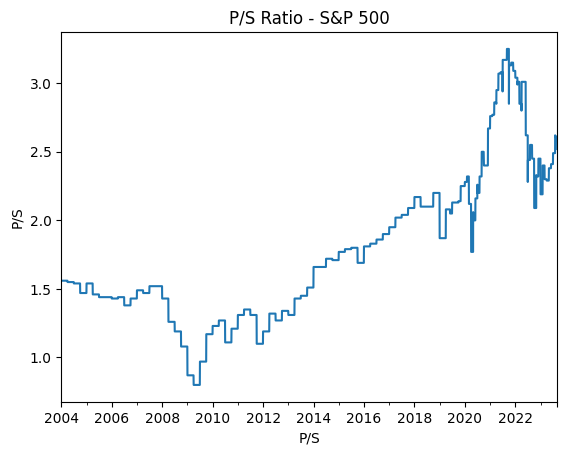

In [210]:
# plot P/S Ratio
sp500_pe_plot = sp500_rates['price_sales_ratio'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/S")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/S Ratio - S&P 500')

>Obecnie wartość P/S Ratio jest dosyć wysoka. Widać wyraźny trend wzrostowy z maksimum w 2021r. Minimum w 2009r.

>**Dividend Yield** - (kolumna - 'div_yield')
>
>Wskaźnik Dividend Yield (Wydajność Dywidendy) to wskaźnik finansowy, który pomaga inwestorom ocenić stopę zwrotu z dywidend, jaką mogą uzyskać inwestując w akcje danej spółki. Wyraża on procentowy stosunek rocznej dywidendy wypłacanej przez spółkę do jej aktualnej ceny akcji. 
>
>Wskaźnik Dividend Yield informuje inwestorów o tym, ile procentowo dywidendy stanowią w stosunku do aktualnej wartości rynkowej akcji. Wyższy Dividend Yield oznacza, że inwestorzy mogą oczekiwać wyższej stopy zwrotu z dywidend w porównaniu do ceny akcji. Jest to szczególnie atrakcyjne dla inwestorów poszukujących stałego i stabilnego dochodu z inwestycji.
Jednak warto pamiętać, że wyższy Dividend Yield może być spowodowany przez niższą cenę akcji, co może wynikać z różnych czynników, w tym z niedocenienia spółki lub problemów finansowych. Dlatego inwestorzy powinni oceniać Dividend Yield w kontekście innych czynników, takich jak stabilność i wzrost dywidendy, zdolność spółki do generowania dochodu oraz ogólna sytuacja na rynku.

Text(0.5, 1.0, 'Dividend Yield - S&P 500')

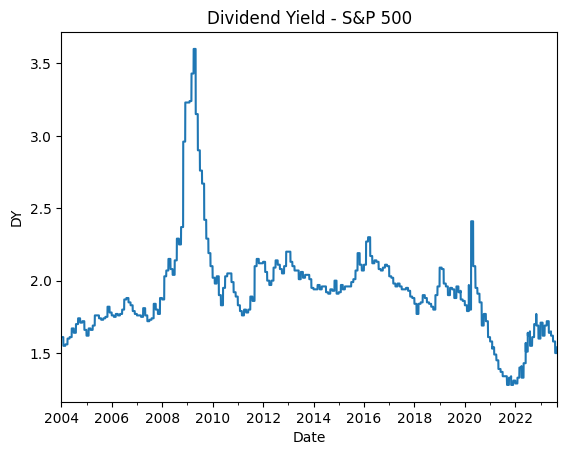

In [211]:
# plot Dividend Yield
sp500_pe_plot = sp500_rates['div_yield'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("DY")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Dividend Yield - S&P 500')

>Największe wartośći zwrot z dywidendy miał w czasie kryzysu z 2008r. Najniższe wartośći na przełomie 2021/2022r. Obecnie wartość nie jest za wysoka i wynosi około 1.5%.

>**Dividend Growth** - (kolumna - 'div_growth')
>
>Wskaźnik Dividend Growth (Wzrost Dywidendy) to wskaźnik finansowy mierzący tempo wzrostu dywidend wypłacanych przez spółkę, idneks w ciągu określonego okresu czasu. Jest to wskaźnik często analizowany przez inwestorów, zwłaszcza tych, którzy poszukują inwestycji, które regularnie zwiększają swoje wypłaty dywidendowe. Wzrost dywidend dla spółki jest uważany za wskaźnik zdrowego i stabilnego zarządzania finansami spółki oraz może sugerować, że spółka ma perspektywy wzrostu.
>
>Wskaźnik Dividend Growth wyraża względny wzrost dywidendy jako procent. Wskaźnik Dividend Growth jest ważnym narzędziem dla inwestorów, ponieważ może świadczyć o zdolności spółki do generowania rosnącego dochodu dla swoich akcjonariuszy. Jednak warto zwrócić uwagę, że wzrost dywidendy może być wynikiem wielu czynników, w tym poprawy wyników finansowych, zysków spółki, a także polityki dywidendowej zarządu. Jednak w tym indeksie mamy 500 spółek więc pojedyncze specyficzne zachowania spółek nie mają tak dużej wagi i widzimy jak ogólnie cały rynek prowadzi politykę dywidend.
>
>Wskaźnik tutaj jest obliczany kwartalnie. Czy zmiana procentowa jest oblicznana na podstawie wysokości dywidend z dwóch ostatnich kwartałów. Dzięki czemu będzię można zauważyć szybciej zmiany na rynku, ale może być więcej szumu, nagłych zmian.

Text(0.5, 1.0, 'Dividend Growth - S&P 500')

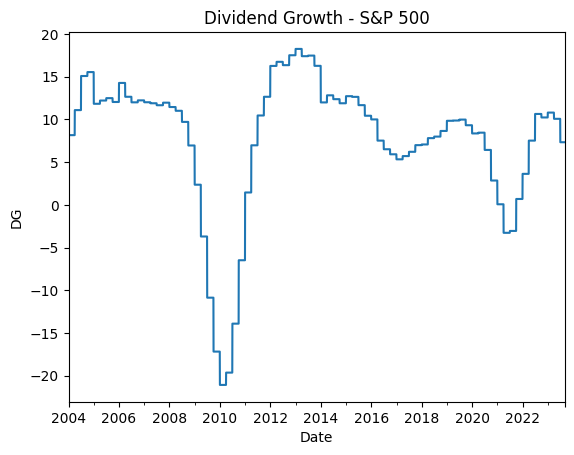

In [212]:
# plot Dividend Groeth
sp500_pe_plot = sp500_rates['div_growth'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("DG")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Dividend Growth - S&P 500')

Na wykresie widać duży spadek dywidend dla okresów związanych z pogorszeniem sytuacji gospodarczej. Co wiąże się z mniejszymi zyskami w tym okresie. Obecnie wartość Dividend Growth wynosi 7,33%.

**<font color="#5963ab" size="4">usa_eco_rates</font>**

opis po co

In [213]:
# load the dataset
macro_data = pd.read_csv('/kaggle/input/usa-sp500-fundamentals/USA_SP500_Fundamentals_2004_2023_Combined.csv', index_col='date')
macro_data.index = pd.to_datetime(macro_data.index)
# make all column headers lowercase
macro_data.columns = macro_data.columns.str.lower()
macro_data

usa_eco_rates = macro_data[[' gdp', 'gdp_percent_change', 'unemploy_rate','pmi_index', 'cpiaucsl_pch','fed_effective_rate', 'fed_effect_rate_pch','10usy_bond_yield', 'cons_sent',
       'cons_sent_percent_change']]
usa_eco_rates.info()

#divide data to two data frames, data related with S&P 500 and USA ecomony
sp500_rates = macro_data[['pe', 'cape', 'earn_yield','pbv', 'price_sales_ratio','div_yield', 'div_growth']]
sp500_rates.info()
usa_eco_rates

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183 entries, 2004-01-01 to 2023-08-31
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0    gdp                      7183 non-null   float64
 1   gdp_percent_change        7183 non-null   float64
 2   unemploy_rate             7183 non-null   float64
 3   pmi_index                 7183 non-null   float64
 4   cpiaucsl_pch              7183 non-null   float64
 5   fed_effective_rate        7183 non-null   float64
 6   fed_effect_rate_pch       7183 non-null   float64
 7   10usy_bond_yield          7183 non-null   float64
 8   cons_sent                 7183 non-null   float64
 9   cons_sent_percent_change  7183 non-null   float64
dtypes: float64(10)
memory usage: 617.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183 entries, 2004-01-01 to 2023-08-31
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  


,gdp,gdp_percent_change,unemploy_rate,pmi_index,cpiaucsl_pch,fed_effective_rate,fed_effect_rate_pch,10usy_bond_yield,cons_sent,cons_sent_percent_change
date,,,,,,,,,,
2004-01-01,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.26,103.8,12.10
2004-01-02,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-03,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-04,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-05,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.39,103.8,12.10
...,...,...,...,...,...,...,...,...,...,...
2023-08-27,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.23,69.5,-2.93
2023-08-28,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.21,69.5,-2.93
2023-08-29,26798.60,1.01,3.8,46.4,0.17,5.33,0.21,4.12,69.5,-2.93


**<font color="#5963ab" size="4">goog_trend</font>**

>Google Trends to narzędzie dostarczane przez Google, które umożliwia analizowanie popularności i wyszukiwań określonych fraz lub słów kluczowych w wyszukiwarce Google w określonym czasie i w określonych regionach geograficznych. To narzędzie pozwala zrozumieć, jakie tematy są popularne w danym momencie oraz jak zmienia się ich popularność w czasie.
>
>Google Trends jest używane w różnych celach, takich jak analiza rynku, badanie trendów marketingowych, badanie zainteresowań społeczności online, śledzenie popularności produktów i wiele innych. Jest to przydatne narzędzie zarówno dla profesjonalistów w dziedzinie marketingu, jak i dla osób śledzących trendy w danym obszarze tematycznym.


In [142]:
# check for missing values in each column
missing_columns = goog_trend.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
# print all goog_trend data info
print()
pprint(goog_trend.info())


'Missing values in column'
month_trend    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2004-01-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   month_trend  236 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None


Text(0.5, 1.0, 'S&P 500 trend')

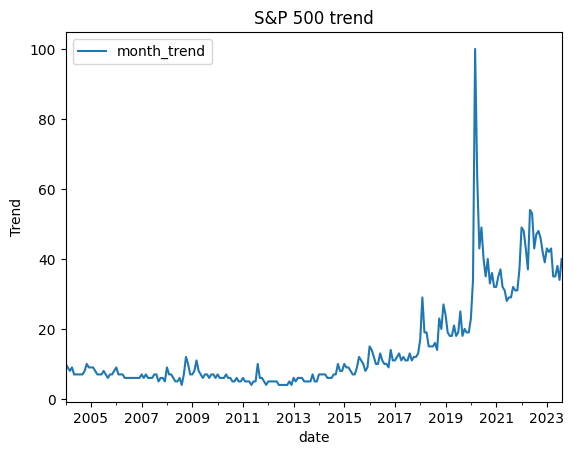

In [143]:
# plot trend
goog_trend_plot = goog_trend.plot.line( use_index = True)
goog_trend_plot.set_ylabel("Trend")
goog_trend_plot.set_title('S&P 500 trend')

>Z wykresu widać początkowo stabilną popularność wyszuliwań indeksu, ale od około roku 2015 następuje większa popularność. Szczyt równy 100 (trend jest mierzony w zakresie od 0 do 100) przypada w okresie wybuchu pandemii Covid-19.

In [146]:
# print date with max popularity
pprint(goog_trend.idxmax().max())
pprint(goog_trend.max().max())

Timestamp('2020-03-01 00:00:00')
100


In [147]:
# seasonability
goog_trend_copy = goog_trend.copy()
goog_trend_copy['year'] = goog_trend_copy.index.year
goog_trend_copy['month'] = goog_trend_copy.index.month
print(goog_trend_copy['year'].unique())
goog_trend_copy.columns

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


Index(['month_trend', 'year', 'month'], dtype='object')

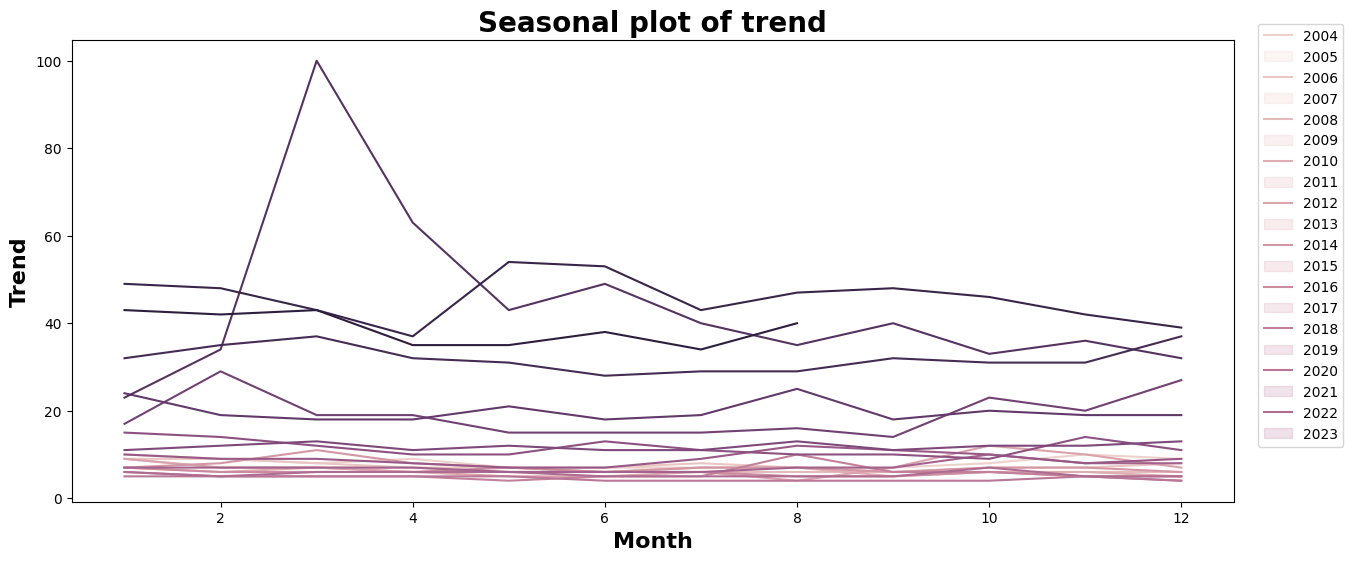

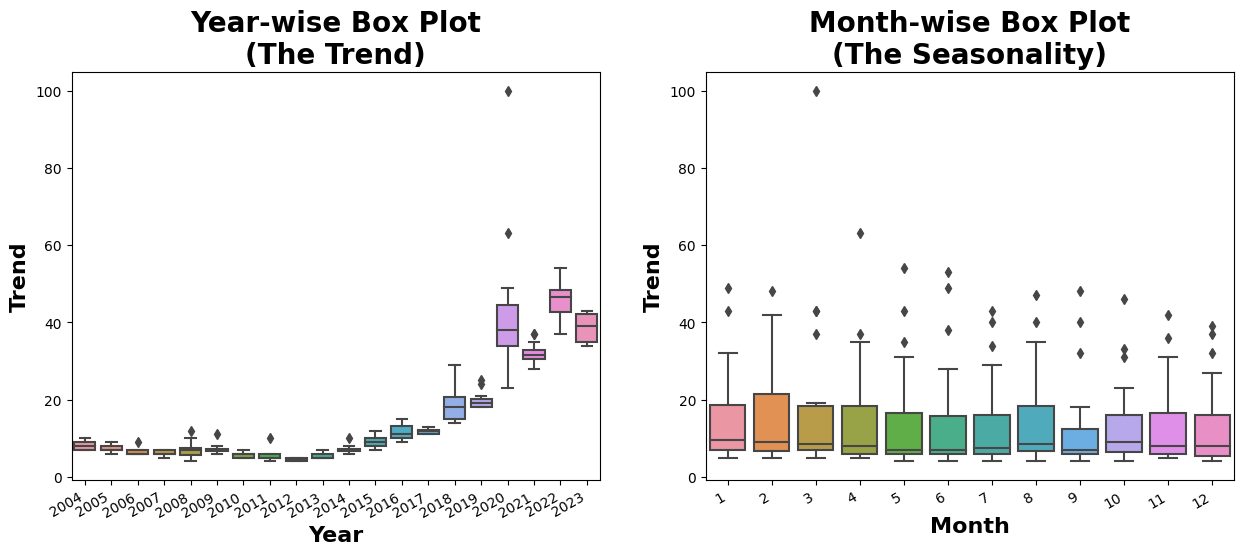

In [148]:
# seasonability of trend column
column = "month_trend"
# create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=goog_trend_copy['month'], y=goog_trend_copy[column], hue = goog_trend_copy['year'])

# format the plot
ax.set_title('Seasonal plot of trend', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=goog_trend_copy['year'], y=goog_trend_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=goog_trend_copy['month'], y=goog_trend_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Volume**

>Dla poszczególnych lat nie widać wyraźnej sezonowości. Widoczny jest duży wzrost popularnoośći frazy "S&P 500" w marcu 2020r.

**Year wise Box Plot**

>Na tym wykresie trend jest prez pierwsze 10 lat i stabilny na równym poziomie. Następnie widać coraz większą popularność wyszukiwań, co może swiadczyć o większej liczbie osób zaintereowanych inwestowaniem. Największą mediana wyniosła dla roku 2022. Największa zmienność jest dla roku 2020 jest to związane z pandemią. Znaczne wartości odstające pojawiają siętakżę w tym roku.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Nie można stwerdzić isteniejącej sezonowości 

Text(0, 0.5, 'Trend')

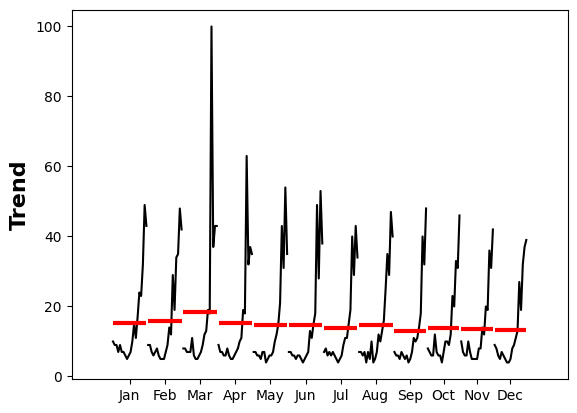

In [172]:
# aggregating trend to monthly scaled index
fig, ax = plt.subplots()

month_plot(goog_trend['month_trend'], ax=ax);
ax.set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

>Nie widać dużej zmienności dla poszczególnych miesięcy dla tych danych. Jedynie marzec ma większą średnią popularnośc. Co jest związane z marcem 2020r. i osiągnieceim największej popularności. Znacznie większej niż dla` innych okresów.